1. Memory saver
2. In memory store
3. self RAG after getting the final answer from the supervisor ( check hallucination, Error handling node, fallback and transform query- evaluate if needed) - rerun from start after rewriting query
4. Evalutate RAG- Ragas metric
5. Error handlers
6. Logging mechanism
7. Generates in .md files

user inputs: Tone, sentiment, style and others
learn from one agent and apply to other


In [2]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core  faiss-cpu  pypdf langchain_community mdutils datasets langchain_huggingface xmltodict sentence-transformers langchain_groq langchain_ollama langchain_mistralai fitz jq

In [3]:
import nest_asyncio
from typing import List, TypedDict, Any, Tuple
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END, START
from datetime import date, datetime
from langgraph.checkpoint.memory import MemorySaver

nest_asyncio.apply()

***Data Ingestion and Embedding***

In [4]:

from PIL import Image
import io
import os
from dotenv import load_dotenv

import google.generativeai as genai
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
#from langchain_cohere import ChatCohere, CohereEmbeddings
# Load environment variables from a .env file
from google.colab import userdata
os.environ["OPENAI_API_KEY"]=userdata.get('OPENAI_API_KEY')

## Langsmith tracking
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]=userdata.get('LANGCHAIN_API_KEY')
os.environ["TAVILY_API_KEY"]=userdata.get('TAVILY_API_KEY')


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Write a helper file
from langchain.document_loaders import TextLoader, CSVLoader, JSONLoader

#with open('/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/utility.py', 'r') as testwritefile:
#    print(testwritefile.read())
print("Hello utility!")
def load_files(file_paths):
    documents = []
    for file in file_paths:
        extension = get_file_type(file)
        print("Extension", extension)
        if extension == '.txt':
            loader = TextLoader(file)
        elif extension == '.csv':
            loader = CSVLoader(file)
        elif extension == '.json':
            loader = JSONLoader(file, jq_schema=".",json_lines=True,text_content=False)
        elif extension == '.pdf':
            loader = PyPDFLoader(file)
        else:
            continue
        documents.extend(loader.load())
    return documents

def get_file_type(file_path):
    _, extension = os.path.splitext(file_path)
    return extension.lower()



Hello utility!


In [7]:
%%writefile 'constants.py'
foldersjson={
    "terminologyDataset":"/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset",
    "trainingData":"/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/trainingData",
    "testData":"/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/testData",
}
MODEL_NAME=""

Writing constants.py


In [8]:
!cp utility.py '/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/'
!cp constants.py '/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/'

cp: cannot stat 'utility.py': No such file or directory


In [12]:
from constants import *

print(foldersjson)

{'terminologyDataset': '/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset', 'trainingData': '/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/trainingData', 'testData': '/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/testData'}


**Create terminology Knowledge Base**

In [13]:
import getpass
import os
allFileswithPath=[]
terminologyDataset=None

folders=foldersjson["terminologyDataset"]
for item in os.listdir(folders):
  filewithPath=folders+"/"+item
  print(filewithPath)
  allFileswithPath.append(filewithPath)


/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset/P5.pdf
/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset/P3.pdf
/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset/P6.pdf
/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset/P2.pdf
/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/terminologyDataset/P4.pdf


In [14]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings


LangChain PyPDF loader mainly focusses on text data. I am using this loader as I need only textual data to understand the terminologies stated in the papers.

In [15]:
#NO NEED TO RUN THIS CODE WHEN THE DATABASE IS ALREADY CREATED
documents=load_files(allFileswithPath)
text_splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=100)
final_documents=text_splitter.split_documents(documents)
embeddings=OpenAIEmbeddings()
vecStore=FAISS.from_documents(final_documents,embeddings)
indexName= "allPapers"
# Save the vector DB to your local
dbAllPapaers =vecStore.save_local(folder_path="/content/drive/MyDrive/Database", index_name=indexName)

Extension .pdf
Extension .pdf
Extension .pdf
Extension .pdf
Extension .pdf


<ipython-input-15-a0e1f690735b>:5: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings=OpenAIEmbeddings()


retrieve all the Paper data

In [16]:
from langchain.tools.retriever import create_retriever_tool
dbAllPapaers=FAISS.load_local(folder_path="/content/drive/MyDrive/Database", index_name=indexName, embeddings=OpenAIEmbeddings(),allow_dangerous_deserialization=True)
allPapersRetreiever=dbAllPapaers.as_retriever()

***Terminology Knowledge base LangGraph***
1. Using the retriever as a tool
2. Creating a prompt
3. Adding a websearch as another chain
4. Store the results of all the terminologies used into the Vector Database
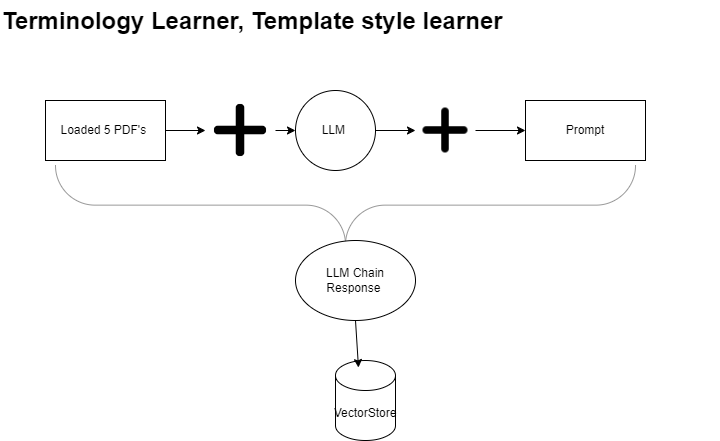




In [55]:
### Router
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )
# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
terminologyChainSystemPrompt = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to science magazine and nature communications papers.
Use the vectorstore for questions related to the terminologies used and their meanings.
When a terminology is not understood fully, use web-search. """
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", terminologyChainSystemPrompt),
        ("human", "{question}"),
    ]
)
question_router = route_prompt | structured_llm_router

In [56]:
def route_question(state):
    """
    Route question to web search or RAG.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


In [57]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [58]:
### Generate
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
# Prompt
prompt = hub.pull("rlm/rag-prompt")
# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)
# Chain
rag_chain = prompt | llm | StrOutputParser()

In [59]:
from typing import List
from typing_extensions import TypedDict
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[str]

In [60]:
def human_feedback(state):
    print("---human_feedback---")
    pass

In [61]:
from langchain.schema import Document
def web_search(state):
    """
    Web search based on the question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with documents and generation with the generated answers
    """
    print("---WEB SEARCH---")
    question = state["question"]
    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents = web_results
    print("Web Documents: "+str(documents))
    print("---GENERATE---")
    # Web generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents , "question": question,"generation": generation}

In [62]:
def generatevecDB(state):
    """
    Generate answer
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---RETRIEVE---")
    question = state["question"]
    documents = allPapersRetreiever.invoke(question)
    print("---GENERATE---")
    question = state["question"]
    state["documents"] =documents

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [63]:
def generatevecDB(state):
    """
    Generate answer
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---RETRIEVE---")
    question = state["question"]
    documents = allPapersRetreiever.invoke(question)
    print("---GENERATE---")
    question = state["question"]
    state["documents"] =documents
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}



In [64]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)
answer_grader = answer_prompt | structured_llm_grader
#TEST
#answer_grader.invoke({"question": question, "generation": generation})

In [65]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.
    Args:
        state (dict): The current graph state
    Returns:
        str: Decision for next node to call
    """
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    print("---GRADE GENERATION vs QUESTION---")
    score = answer_grader.invoke({"question": question, "generation": generation})
    grade = score.binary_score
    if grade == "yes":
        print("---DECISION: GENERATION ADDRESSES QUESTION---")
        return "useful"
    else:
        print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        return "not useful"

In [66]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("vectorstore", generatevecDB)  # generatae
#workflow.add_node("human_feedback", human_feedback)

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "vectorstore",
    },
)
workflow.add_conditional_edges(
    "vectorstore",
    grade_generation_v_documents_and_question,
    {
        "useful": END,
        "not useful": "web_search",
    },
)
workflow.add_edge("web_search",END)

memory = MemorySaver()
#compile the graph
app = workflow.compile(checkpointer=memory)

# Compile
#app = workflow.compile()

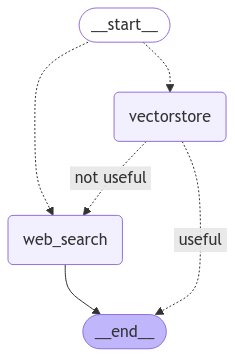

In [67]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("Something happened")
    pass

In [68]:
#1: "List all the terminologies used in the papers along with what they mean.",

from pprint import pprint
terminologiesUsed={}
questionprompts={
    "terahertz": "What is terahertz measurements according to the paper ?",
    "simulations": "What is simulations according to the paper?",
    "data analysis":"What is data analysis according to the paper?",
    "coherence":"What is conherence according to the papers?",
    "polarization of light":"What is polarization of light according to the papers?",
    "mid-infrared ":"What is polarization of mid-infrared according to the papers?",
    "near-field effects":"What is near-field effects according to the papers?",
    "spatial coherence":"What is spatial coherence according to the papers?",
    "thermal sources":"What is thermal sources according to the papers?",
    "thermal emission":"What is thermal emission according to the papers?",
    "biological sensing":"What is biological sensing according to the papers?",
    "topological photonics":"What is topological photonics according to the papers?",
    "chiroptics":"What is chiroptics according to the papers?",
    "Aperture":"What is Aperture according to the papers?",
    "Metalscreen":"What is Metalscreen according to the papers?",
    "Field excitation":"What is Field excitation according to the papers?",
    "PEC boundary":"What is PEC boundary according to the papers?",
    "PMC boundary":"What is PMC boundary according to the papers?",
    "Ex field":"What is Ex field according to the papers?",
    "PMMA cladding":"What is PMMA cladding according to the papers?",
    "frequency":"What is frequency according to the papers?",
    "Metalscreen,":"What is Metalscreen according to the papers?",
    "Field excitation":"What is Field excitation according to the papers?",
    "plasmonic metamaterial":"What is plasmonic metamaterial according to the papers?",
    "silver nanorods":"What is silver nanorods according to the papers?",
    "optical feedback":"What is optical feedback according to the papers?",
    "surface plasmon" :"What is surface plasmon according to the papers?",
    "amplification":"What is amplification according to the papers?",
    "lasing threshold":"What is lasing threshold according to the papers?",
    "lasing oscillations":"What is lasing oscillations according to the papers?" ,
    "3D plasmonic nanorod":"What is 3D plasmonic nanorod according to the papers?",
    "metamaterials":"What is metamaterials according to the papers?",
}
thread = {"configurable": {"thread_id": "1"}}

# Run
answers = {}
for qkey, qq in questionprompts.items():
  inputs = {"question": qq}
  print("Question: "+ qq)
  for output in app.stream(inputs,thread):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        pprint("Value: "+str(value))
    pprint("\n---\n")
  print("Key:"+ str(key))
  terminologiesUsed[qkey] = value["generation"]
  # Final generation
  pprint("FINAL Answer: "+str(value["generation"]))
  #pprint(value["generation"])

Question: What is terahertz measurements according to the paper ?
---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---GENERATE---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'vectorstore':"
("Value: {'question': 'What is terahertz measurements according to the paper "
 "?', 'generation': 'Terahertz measurements in the paper were performed using "
 'a terahertz near-field microscope. The measurements involved a terahertz '
 'emitter consisting of striplines on gallium arsenide, producing a THz pulse '
 'focused on a chip with a detector antenna. The data analysis and simulations '
 "were performed by the authors involved in the study.', 'documents': "
 "[Document(metadata={'source': '/content/drive/MyDrive/Colab "
 "Notebooks/colab_data/ResearchPubAI/terminologyDataset/P3.pdf', 'page': 7}, "
 "page_content='microscope. A.T. and K.J.K. performed the terahertz "
 'measurements. A.T. performed the\\nsimulations. A.T., B.T.K. and A.A

In [69]:
terminologiesUsed

{'terahertz': 'Terahertz measurements in the paper were performed using a terahertz near-field microscope. The measurements involved a terahertz emitter consisting of striplines on gallium arsenide, producing a THz pulse focused on a chip with a detector antenna. The data analysis and simulations were performed by the authors involved in the study.',
 'simulations': 'Simulations, according to the paper, were performed by A.T. in the context of terahertz measurements. The simulations were part of the data analysis process for the research presented in the manuscript.',
 'data analysis': 'Data analysis is the process of systematically applying statistical and/or logical techniques to describe, condense, and evaluate data. It involves converting gathered data into meaningful information to gain additional insight, answer research questions, or confirm hypotheses. Data analysis can be quantitative, qualitative, or mixed methods.',
 'coherence': 'Coherence, according to the papers, refers t

In [70]:
import json
with open('terminologiesKnowledgeBase.json', 'w') as f:
    json.dump(terminologiesUsed, f)
!cp terminologiesKnowledgeBase.json '/content/drive/MyDrive/Colab Notebooks/colab_data/ResearchPubAI/'

In [71]:
#NO NEED TO RUN THIS CODE WHEN THE DATABASE IS ALREADY CREATED
allPaths=["terminologiesKnowledgeBase.json"]
documents=load_files(allPaths)
text_splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=100)
final_documents=text_splitter.split_documents(documents)
embeddings=OpenAIEmbeddings()
vecStore=FAISS.from_documents(final_documents,embeddings)
indexName= "terminologiesKnowledgeBase"
# Save the vector DB to your local
dbAllPapaers =vecStore.save_local(folder_path="/content/drive/MyDrive/Database", index_name=indexName)

Extension .json
